In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [6]:
df = pd.read_csv(r"C:\Users\rabea\Desktop\modified_train.csv")
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,char_count,word_count,clean_text,HashtagCount,MentionCount,URLCount,...,has_@amazon,URLList,TweetDate,TweetWeekday,CleanLocation,Mentions,Hashtags,fully_clean_text,text_len,token_lens
0,London -UK,2020-03-18,impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,279,48,impct of #coronavirus i hve sen hw civilizd pp...,3,0,0,...,False,[],2020-03-18,Wednesday,london -uk,[],"['#coronavirus', '#uk', '#uk']",impct of coronavirus i hve sen hw civilizd ppl...,48,79
1,"Victoria, BC, Canada",2020-03-21,"okay, so i just checked the drug prices for #p...",Positive,310,38,"okay, so i just checked the drug prices for #p...",9,0,0,...,False,['https://t.co/ovypmnsmax'],2020-03-21,Saturday,victoria,[],"['#plaquenil', '#aralen', '#chloroquine', '#ch...",okay so i just checked the drug prices for pla...,36,79
2,"Berlin, Deutschland",2020-04-02,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,Neutral,263,34,eine wahre #coronageschichte:\r\r\n\r\r\nwenn ...,3,0,0,...,False,[],2020-04-02,Thursday,berlin,[],"['#coronageschichte', '#coronadiã', '#feelthejr']",eine wahre coronageschichte wenn dir an der su...,29,78
3,United Kingdom,2020-03-21,hiked prices in the face of the covid-19 crise...,Negative,296,52,hiked prices in the face of the covid-19 crise...,0,0,0,...,False,[],2020-03-21,Saturday,united kingdom,[],[],hiked prices in the face of the covid19 crises...,47,77
4,NaN,2020-04-09,for sell sterile disposable anti bacterial wet...,Negative,303,33,for sell sterile disposable anti bacterial wet...,13,0,0,...,False,['https://t.co/jizbddszet'],2020-04-09,Thursday,NaN,[],"['#disinfectant', '#covid', '#covid_19', '#cor...",for sell sterile disposable anti bacterial wet...,33,77


### checking sentiment distrbution

<Axes: xlabel='Sentiment'>

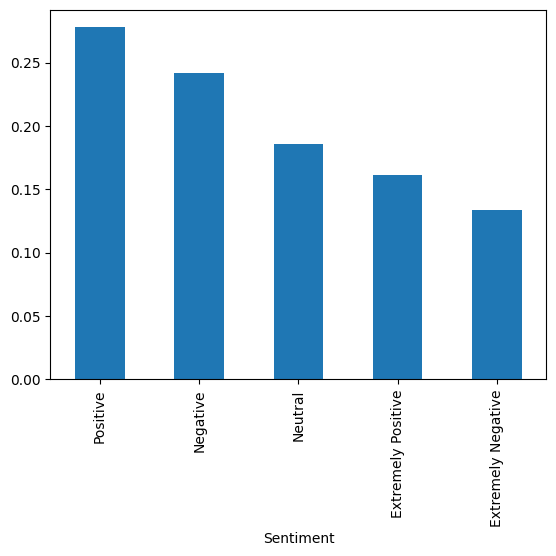

In [8]:
df['Sentiment'].value_counts(normalize=True).plot(kind='bar')


<Axes: >

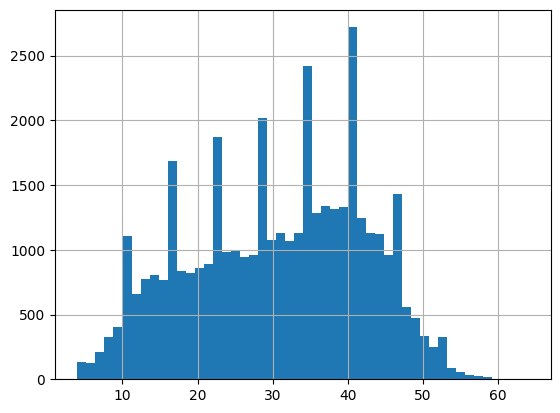

In [10]:
df['TweetLength'] = df['OriginalTweet'].str.split().str.len()
df['TweetLength'].hist(bins=50)


### Lets see how it tokenizes

count    41047.000000
mean        47.268911
std         17.404742
min          6.000000
25%         34.000000
50%         48.000000
75%         61.000000
max        148.000000
Name: TokenCount, dtype: float64

Percentiles:
50th percentile: 48
75th percentile: 61
90th percentile: 69
95th percentile: 74
99th percentile: 84
100th percentile: 148


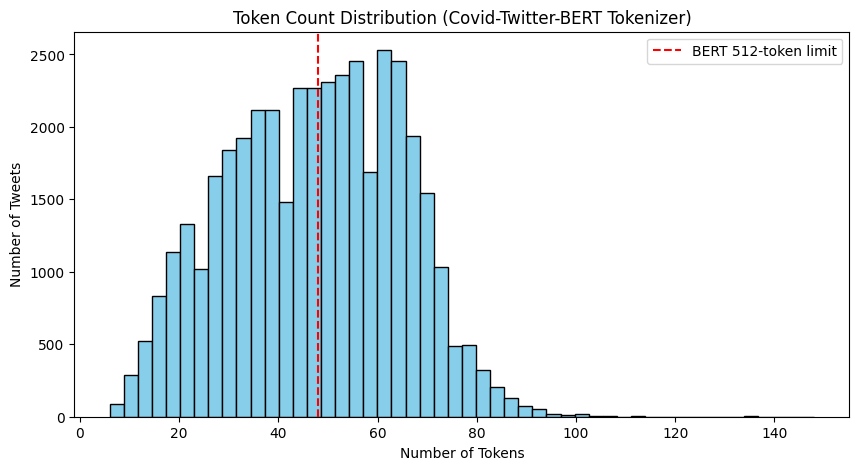

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "digitalepidemiologylab/covid-twitter-bert"
)

# Count tokens (no truncation so you see true lengths)
df['TokenCount'] = df['OriginalTweet'].apply(
    lambda x: len(tokenizer.encode(str(x), add_special_tokens=True, truncation=False))
)
lengths_series = df['TokenCount']
print(lengths_series.describe())
print("\nPercentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    print(f"{p}th percentile: {lengths_series.quantile(p/100):.0f}")
# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(df['TokenCount'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(lengths_series.median(), color='red', linestyle='--', label='BERT 512-token limit')
plt.title('Token Count Distribution (Covid-Twitter-BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()


In [27]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "digitalepidemiologylab/covid-twitter-bert"
)

# Take first 5 tweets
for idx, text in enumerate(df['OriginalTweet'].head(5), start=1):
    print("="*80)
    print(f"Tweet #{idx} - Original:")
    print(text)
    
    # Tokenization
    tokens = tokenizer.tokenize(text)
    print("\nTokens:")
    print(tokens)
    
    # Token IDs
    print("\nToken IDs:")
    print(tokenizer.convert_tokens_to_ids(tokens))


Tweet #1 - Original:
impct of #coronavirus i hve sen hw civilizd ppl fighting ovr food commodities n toilet rolls in #uk, busy in stockpiling. mjrity of superstores gone out of stock, shlvs r empty. no oil,atta,vegetables,bread, fruits, rice
sems lke ppl will die nt of corona bt of strvtin in #uk.

Tokens:
['imp', '##ct', 'of', '#', 'corona', '##virus', 'i', 'h', '##ve', 'sen', 'h', '##w', 'civil', '##iz', '##d', 'pp', '##l', 'fighting', 'o', '##vr', 'food', 'commodities', 'n', 'toilet', 'rolls', 'in', '#', 'uk', ',', 'busy', 'in', 'stock', '##pi', '##ling', '.', 'm', '##j', '##rity', 'of', 'super', '##stor', '##es', 'gone', 'out', 'of', 'stock', ',', 'sh', '##l', '##vs', 'r', 'empty', '.', 'no', 'oil', ',', 'at', '##ta', ',', 'vegetables', ',', 'bread', ',', 'fruits', ',', 'rice', 'se', '##ms', 'l', '##ke', 'pp', '##l', 'will', 'die', 'nt', 'of', 'corona', 'bt', 'of', 'st', '##r', '##v', '##tin', 'in', '#', 'uk', '.']

Token IDs:
[17727, 6593, 1997, 1001, 21887, 23350, 1045, 1044, 372

In [35]:
import re, unicodedata
import pandas as pd
import emoji

USER_FILLER = "twitteruser"
URL_FILLER  = "twitterurl"

_username = re.compile(r'(^|[^@\w])@(\w{1,15})\b', flags=re.UNICODE)
# _url = re.compile(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', flags=re.UNICODE)

# curly quotes/dashes -> ascii; tweak map if you like
PUNC_MAP = str.maketrans("‘’´“”–—", "'''\"\"--")

def standardize_punct(s: str) -> str:
    return s.translate(PUNC_MAP)

def remove_unicode_symbols_so(s: str) -> str:
    # Drop characters whose Unicode category starts with 'So' (Symbol, other)
    return ''.join(ch for ch in s if unicodedata.category(ch) != 'So')

def replace_usernames(s: str) -> str:
    # Replace any @handle with filler, and space it
    s = _username.sub(lambda m: (m.group(1) + f" {USER_FILLER} "), s)
    # Compress repeated fillers: e.g., " @user @user " -> " 2 twitteruser "
    while f"{USER_FILLER} {USER_FILLER}" in s:
        s = s.replace(f"{USER_FILLER} {USER_FILLER}", f"2 {USER_FILLER}")
    return ' '.join(s.split())

# def replace_urls(s: str) -> str:
#     s = _url.sub(f" {URL_FILLER} ", s)
#     # Compress repeated fillers similarly
#     while f"{URL_FILLER} {URL_FILLER}" in s:
#         s = s.replace(f"{URL_FILLER} {URL_FILLER}", f"2 {URL_FILLER}")
#     return ' '.join(s.split())

def clean_like_ctbert(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove common RT markers first
    s = re.sub(r"^RT\s+@[\w_]+:\s*", "", text)
    # Standardize punctuation
    s = standardize_punct(s)
    # Replace usernames/urls
    s = replace_usernames(s)
    # Emoji to ascii aliases (e.g., :smile:)
    s = emoji.demojize(s, language='en')
    # Drop stray “symbol other” chars
    s = remove_unicode_symbols_so(s)
    # Collapse whitespace
    s = ' '.join(s.split())
    return s

# Apply to your DF
# Assuming your raw text column is 'OriginalTweet'
df['CleanTweet_eda2'] = df['OriginalTweet'].apply(clean_like_ctbert)

# (Optional) de-duplicate & drop pure retweets if needed
df = df.drop_duplicates(subset=['CleanTweet_eda2']).reset_index(drop=True)
#making urls like original train
df['CleanTweet_eda2'] = df['CleanTweet_eda2'].str.replace(r"\bURL\b", "twitterurl", regex=True)

df['CleanTweet_eda2'].head()

0    impct of #coronavirus i hve sen hw civilizd pp...
1    okay, so i just checked the drug prices for #p...
2    eine wahre #coronageschichte: wenn dir an der ...
3    hiked prices in the face of the covid-19 crise...
4    for sell sterile disposable anti bacterial wet...
Name: CleanTweet_eda2, dtype: object


In [37]:
!pip install langdetect

from langdetect import detect, DetectorFactory
import pandas as pd

DetectorFactory.seed = 0  # for reproducible results

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

# Example: drop non-English
df = df[df["CleanTweet_eda2"].apply(is_english)].reset_index(drop=True)

print(df["CleanTweet_eda2"].head(5))


0    impct of #coronavirus i hve sen hw civilizd pp...
1    okay, so i just checked the drug prices for #p...
2    hiked prices in the face of the covid-19 crise...
3    for sell sterile disposable anti bacterial wet...
4    grap some for your family and keep in safe, #h...
Name: CleanTweet_eda2, dtype: object


### now we check tokens again after cleaning

count    40910.000000
mean        46.812295
std         16.778019
min          6.000000
25%         34.000000
50%         48.000000
75%         60.000000
max        149.000000
Name: TokenCount_2, dtype: float64

Percentiles:
50th percentile: 48
75th percentile: 60
90th percentile: 68
95th percentile: 72
99th percentile: 83
100th percentile: 149


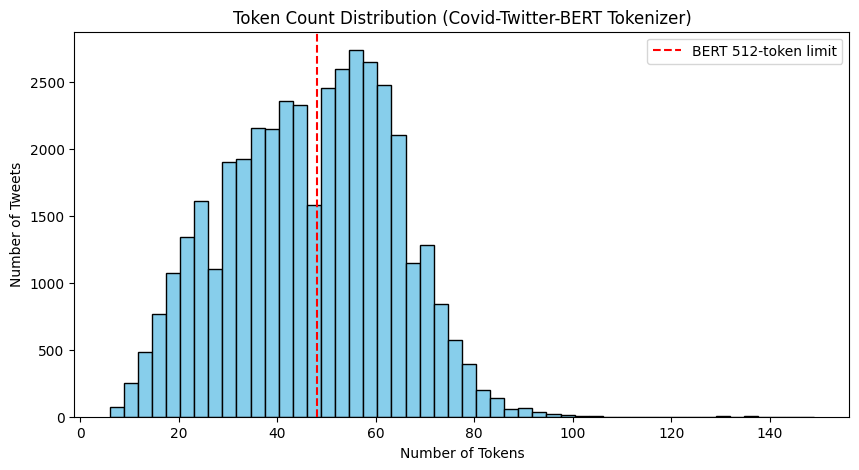

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "digitalepidemiologylab/covid-twitter-bert"
)

# Count tokens (no truncation so you see true lengths)
df['TokenCount_2'] = df['CleanTweet_eda2'].apply(
    lambda x: len(tokenizer.encode(str(x), add_special_tokens=True, truncation=False))
)
lengths_series = df['TokenCount_2']
print(lengths_series.describe())
print("\nPercentiles:")
for p in [50, 75, 90, 95, 99, 100]:
    print(f"{p}th percentile: {lengths_series.quantile(p/100):.0f}")
# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(df['TokenCount_2'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(lengths_series.median(), color='red', linestyle='--', label='BERT 512-token limit')
plt.title('Token Count Distribution (Covid-Twitter-BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.legend()
plt.show()
